<a href="https://colab.research.google.com/github/shaffy-dev/Credit-Risk-Prediction-MLP-vs.-1D-Tiny-CNN-/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stage 2: Predictive Analysis**

## **Process Two: Multiayer Perceptron (MLP)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


___
1. ### Import Libraries for MLP Model  
This cell brings in all the packages we’ll need to load data, split it, plot results, calculate metrics, and build/train our multi-layer perceptron (MLP) with Keras.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, callbacks

___
2. ### Load Raw Data and Inspect  
This cell clears any existing Keras session, reads the raw CSV into a DataFrame, prints its size and the proportion of default vs. non-default loans, and shows the first few rows to verify the load.


In [ ]:
# Clear previous TensorFlow models from memory
tf.keras.backend.clear_session()

# Load the raw loan data from Google Drive
DATA_PATH = '/content/drive/MyDrive/cs_project/data.csv'
df = pd.read_csv(DATA_PATH)

# Print number of rows and columns for a quick sanity check
print(f"Loaded DataFrame: {df.shape[0]:,} rows × {df.shape[1]} columns")

# Show class balance for the target column
LABEL_COL = 'default_ind'
print("\nClass distribution:")
print(df[LABEL_COL].value_counts(normalize=True).round(3))
print("")

# Display the first five rows to verify content
df.head()


<ipython-input-3-bb536c1be0c7>:6: DtypeWarning: Columns (17,45,53) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(DATA_PATH)


Loaded DataFrame: 855,969 rows × 73 columns

Class distribution:
default_ind
0    0.946
1    0.054
Name: proportion, dtype: float64



,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,default_ind
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


___
3. ### Column Audit: Identify Data Types & Missing Values  
In this cell, I split the DataFrame into numeric vs. categorical features, check that the target column is in the right group, list the ten columns with the most missing values, and flag any text columns that really look numeric.


In [ ]:
# Pick out all columns whose pandas dtype is a number
numeric_cols     = df.select_dtypes(include=['number']).columns.tolist()

# Everything else (except the label) is treated as categorical
categorical_cols = [c for c in df.columns if c not in numeric_cols + [LABEL_COL]]

# Print how many numeric vs. categorical columns we have
print(f"Numeric columns: {len(numeric_cols)}")
print(f"Categorical columns: {len(categorical_cols)}\n")

# Make sure our target ended up in the numeric list
print("LABEL_COL in numeric_cols?     ", LABEL_COL in numeric_cols)
print("LABEL_COL in categorical_cols? ", LABEL_COL in categorical_cols)
print("")

# Calculate percentage of missing values in each column
missing_pct = df.isna().mean().mul(100).sort_values(ascending=False)

# Print the top 10 columns by percent missing
print("Top 10 columns by % missing:")
print(missing_pct.head(10).round(1))

# Find any categorical columns where >50% of values could be numbers
suspects = []
for col in categorical_cols:
    coerced      = pd.to_numeric(df[col], errors='coerce')
    success_ratio = coerced.notna().mean()
    if success_ratio > 0.50:
        suspects.append((col, success_ratio))

# If any mixed-type columns were flagged, print them
if suspects:
    print("\nColumns with mixed types that look numeric:")
    for col, ratio in suspects:
        print(f"  {col:>25s}: {ratio:.2%} rows parse as numeric")

print("\nColumn audit complete.")


Numeric columns: 52
Categorical columns: 21

LABEL_COL in numeric_cols?      True
LABEL_COL in categorical_cols?  False

Top 10 columns by % missing:
verification_status_joint    99.9
dti_joint                    99.9
annual_inc_joint             99.9
il_util                      98.6
mths_since_rcnt_il           98.5
max_bal_bc                   98.4
open_acc_6m                  98.4
open_rv_24m                  98.4
inq_last_12m                 98.4
total_cu_tl                  98.4
dtype: float64

Column audit complete.


This shows there are 52 numeric and 21 categorical features, confirms default_ind is numeric, lists the top ten columns with over 98% missing (like verification_status_joint and dti_joint), and finds no text fields that are mostly numeric. The audit ends by saying “Column audit complete,” so I know which columns to drop or clean next.

___
4. ### Drop Ultra-Sparse Columns & Final Clean  
This cell removes any feature with ≥50 % missing values, updates our lists of numeric vs. categorical columns, fills numeric gaps with 0 (and casts to `float32`) and text gaps with `''`, shows the first five rows of the cleaned data, and saves it to Drive.


In [ ]:
# Define threshold for dropping sparsely populated columns
MISSING_THRESH = 0.50

# Identify columns to drop and remove them
drop_cols = missing_pct[missing_pct >= MISSING_THRESH * 100].index.tolist()
df_clean = df.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns: {drop_cols[:10]}…\n")

# Recalculate which columns are numeric vs. categorical
numeric_cols     = df_clean.select_dtypes('number').columns.tolist()
categorical_cols = [c for c in df_clean.columns if c not in numeric_cols + [LABEL_COL]]
print(f"Now numeric={len(numeric_cols)} | categorical={len(categorical_cols)}")

# Exclude the label and ID fields from feature lists
numeric_cols     = [c for c in numeric_cols     if c not in [LABEL_COL, 'id', 'member_id']]
categorical_cols = [c for c in categorical_cols if c != LABEL_COL]
print("Now numeric features:", len(numeric_cols), "categorical features:", len(categorical_cols))

# Clean numeric features: convert, fill NaNs, cast to float32
df_clean[numeric_cols] = (
    df_clean[numeric_cols]
    .apply(pd.to_numeric, errors='coerce')
    .fillna(0.0)
    .astype('float32')
)

# Clean categorical features: convert to string, fill NaNs
for col in categorical_cols:
    df_clean[col] = df_clean[col].astype(str).fillna('')

# Show a preview of the cleaned data
print("\nClean-up complete. Sample after cleaning:")
display(df_clean.head())

# Save the cleaned DataFrame back to Drive
CLEAN_PATH = '/content/drive/MyDrive/data2.parquet'
df_clean.to_parquet(CLEAN_PATH, index=False)
print(f"\nSaved cleaned DataFrame to {CLEAN_PATH}")


Dropped 21 columns: ['verification_status_joint', 'dti_joint', 'annual_inc_joint', 'il_util', 'mths_since_rcnt_il', 'max_bal_bc', 'open_acc_6m', 'open_rv_24m', 'inq_last_12m', 'total_cu_tl']…

Now numeric=33 | categorical=19
Now numeric features: 30 categorical features: 19

Clean-up complete. Sample after cleaning:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,default_ind
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.869995,B,B2,...,nan,01-01-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.830002,C,C4,...,nan,01-09-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,1
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.330002,C,C5,...,nan,01-01-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.309998,C,C1,...,nan,01-01-2015,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.790001,B,B5,...,01-02-2016,01-01-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0



Saved cleaned DataFrame to /content/drive/MyDrive/data2.parquet


This cell dropped 21 super-sparse columns, leaving 30 numeric and 19 categorical features (after excluding IDs and the label). All numeric NaNs were set to 0 and cast to float32, and text NaNs became empty strings. The first five rows of the 52-column cleaned DataFrame are displayed, and the cleaned data is saved to Drive at data2.parquet.

___
5. ### Reload Cleaned Data for MLP  


In [ ]:
# 1) Load the 50%-cleaned DataFrame
CLEAN_PATH = '/content/drive/MyDrive/data2.parquet'
df = pd.read_parquet(CLEAN_PATH)
print("Loaded df:", df.shape)

Loaded df: (855969, 52)


___
6. ### Identify Top Correlated Features  
This cell computes the absolute Pearson correlation between each feature and the target `default_ind`, and prints the top features most strongly linked to loan default.


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# compute absolute correlation with target
corrs = df_clean[numeric_cols + categorical_cols].apply(
    lambda col: pd.to_numeric(col, errors='coerce').corr(df_clean['default_ind'])
).abs().sort_values(ascending=False)

print("Top 10 features by |corr|:", corrs.head(20))

Top 10 features by |corr|: recoveries                 0.475738
collection_recovery_fee    0.330764
out_prncp                  0.225960
out_prncp_inv              0.225959
int_rate                   0.155037
total_rec_late_fee         0.140760
total_rec_prncp            0.090336
last_pymnt_amnt            0.087217
inq_last_6mths             0.074407
tot_cur_bal                0.061478
total_rev_hi_lim           0.057524
emp_title                  0.053472
total_rec_int              0.046050
revol_util                 0.044130
total_pymnt_inv            0.040232
total_pymnt                0.039220
annual_inc                 0.037066
open_acc                   0.021698
total_acc                  0.021087
revol_bal                  0.020696
dtype: float64


Here we see which variables move most closely with loan default in a linear sense. recoveries leads with |corr| ≈ 0.48, followed by collection_recovery_fee (≈ 0.33) and outstanding principal metrics. These top‐ranked features are likely to be the strongest predictors for our MLP model.


___
7. ### Remove Leaky and Identifier Columns  
This cell drops any columns that leak future information (like repayment amounts or dates) and all identifier fields, leaving only the predictors that would be available at loan origination.


In [ ]:
# List of columns to remove because they leak post-loan information or are just IDs
leak_cols = [
  'recoveries',
  'collection_recovery_fee',
  'out_prncp',
  'out_prncp_inv',
  'total_rec_late_fee',
  'total_rec_prncp',
  'last_pymnt_amnt',
  'id',
  'member_id',
  'last_pymnt_d',
  'next_pymnt_d',
  'last_credit_pull_d',
  'issue_d',
  'total_rec_int',
  'total_pymnt',
  'total_pymnt_inv',
  'tot_coll_amt',
  'collections_12_mths_ex_med',
  'policy_code'
]

# Drop those leaky columns from the cleaned DataFrame
df_noleak1 = df_clean.drop(columns = leak_cols)


# Print the new shape to confirm how many features remain
print("New Shape: ", df_noleak1.shape)

New Shape:  (855969, 33)


After removing 19 leaky or ID fields, the DataFrame still contains 855,969 rows but now only 33 columns—all of which represent information available at loan origination.

___
8. ### Split Data into Training, Validation, and Test Sets  
This cell divides our leak-free DataFrame into 70% training, 15% validation, and 15% test subsets—while preserving the default rate in each—and saves them to Drive for future reuse.


In [ ]:
# Split df_noleak1 into 70% train and 30% temporary (for val + test)
train_df, temp_df = train_test_split(
    df_noleak1,
    test_size=0.30,
    stratify=df_clean[LABEL_COL],
    random_state=42
)

# Split temporary set equally into 15% val and 15% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df[LABEL_COL],
    random_state=42
)

# Print row counts for each group
print(f"Rows → train: {len(train_df):,},  val: {len(val_df):,},  test: {len(test_df):,}")

# Quick sanity check: verify default rate stays the same
for name, part in zip(['train', 'val', 'test'], [train_df, val_df, test_df]):
    print(f"{name} default-rate: {part[LABEL_COL].mean():.2%}")

# Save each split as a Parquet file so we don't need to re-clean next time
train_df.to_parquet('/content/drive/MyDrive/loans_train.parquet', index=False)
val_df.to_parquet('/content/drive/MyDrive/loans_val.parquet',   index=False)
test_df.to_parquet('/content/drive/MyDrive/loans_test.parquet', index=False)
print("\nSaved the three splits to Drive.")


Rows → train: 599,178,  val: 128,395,  test: 128,396
train default-rate: 5.43%
val default-rate: 5.43%
test default-rate: 5.43%

Saved the three splits to Drive.


This shows we have 599,178 training rows, 128,395 validation rows, and 128,396 test rows, each holding a consistent default rate around 5.43%. Finally, it writes all three subsets to Drive so future runs can load them directly without repeating the cleaning steps.

___
9. ### Refresh Feature Lists for MLP Model  
This cell recalculates which columns in the training DataFrame are numeric (excluding the target) versus categorical, so we know exactly what to scale and encode before feeding into the MLP.


In [ ]:
# Specify the name of the target column
LABEL_COL = 'default_ind'

# Numeric features: select all number-type columns except the label
numeric_cols = (
    train_df
    .select_dtypes(include=['number'])
    .columns
    .drop(LABEL_COL)
    .tolist()
)

# Categorical features: every other column except the label
categorical_cols = [
    c for c in train_df.columns
    if c not in numeric_cols + [LABEL_COL]
]

# Print counts of each to verify our feature split
print(f"Refreshed features → {len(numeric_cols)} numerics, {len(categorical_cols)} categoricals")


Refreshed features → 17 numerics, 15 categoricals


This confirms that the training set now contains 17 numeric features (to be scaled or normalized) and 15 categorical features (to be encoded), ensuring we know exactly which preprocessing steps to apply before building the MLP.

___
10. ### Build Preprocessing Pipeline: Normalize Numbers & Embed Categories  
This cell defines a small Keras model that normalizes all numeric inputs and hashes+embeds each categorical feature into a dense vector, then concatenates everything into one feature tensor.


In [ ]:
# Clear any existing Keras session to start fresh
tf.keras.backend.clear_session()

# Numeric inputs → Normalization

# Create one Input layer per numeric column, then concatenate them
num_inputs = {c: layers.Input(shape=(1,), name=c) for c in numeric_cols}
num_concat = layers.concatenate(list(num_inputs.values()))

# Build a Normalization layer and adapt it on a sample of the training data
norm = layers.Normalization()
norm.adapt(train_df[numeric_cols].sample(10_000, random_state=42).values)

# Apply normalization to the concatenated numeric tensor
num_proc = norm(num_concat)

# Categorical inputs → Hashing + Embedding
cat_inputs, cat_embeds = {}, []
for c in categorical_cols:
    # Input layer for each text feature
    inp        = layers.Input(shape=(1,), dtype=tf.string, name=c)
    # Hash strings into 1024 bins
    hash_layer = layers.Hashing(num_bins=1024, name=f"{c}_hash")
    h          = hash_layer(inp)
    # Embed each hashed index into an 8-dimensional vector
    emb        = layers.Embedding(input_dim=1024, output_dim=8)(h)
    # Flatten embedding from (1,8) → (8,)
    cat_embeds.append(layers.Flatten()(emb))
    cat_inputs[c] = inp

# Combine numeric and categorical paths
all_inputs   = list(num_inputs.values()) + list(cat_inputs.values())
all_features = layers.concatenate([num_proc] + cat_embeds)

# Create a Keras Model for preprocessing and print its summary
preprocess_model = models.Model(all_inputs, all_features, name="preproc_hash")
preprocess_model.summary(line_length=120)


Model: "preproc_hash"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ term (InputLayer)                 │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ grade (InputLayer)                │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ sub_grade (InputLayer)            │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ emp_title (InputLayer)            │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ emp_length (InputLayer)           │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ home_ownership (InputLayer)       │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ verification_status (InputLayer)  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pymnt_plan (InputLayer)           │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ purpose (InputLayer)              │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ title (InputLayer)                │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ zip_code (InputLayer)             │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ addr_state (InputLayer)           │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ earliest_cr_line (InputLayer)     │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ initial_list_status (InputLayer)  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ application_type (InputLayer)     │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ loan_amnt (InputLayer)            │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼───────────────────

 Total params: 122,915 (480.14 KB)

 Trainable params: 122,880 (480.00 KB)

 Non-trainable params: 35 (144.00 B)

This summary shows a model called preproc_hash that takes each numeric column, normalizes it, and each categorical column, hashes it into 1,024 bins then embeds it into 8 numbers. All those processed tensors are concatenated into a single vector of length 137. With ~122K trainable parameters (from the embeddings), this layer can now turn raw DataFrame columns into a ready-to-feed numeric tensor for the MLP.

___
11. ### Attach & Compile a Compact MLP  
This cell builds a simple feed-forward network on top of our preprocessing model: two hidden layers with batch-norm and dropout, and a sigmoid output for default probability. Then it compiles the model with Adam and metrics for AUC, precision, and recall.


In [ ]:
# First hidden layer: 64 neurons, ReLU activation
x = layers.Dense(64, activation='relu')(preprocess_model.output)

# Stabilize and regularize: batch-norm then 30% dropout
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Second hidden layer: 32 neurons, ReLU activation
x = layers.Dense(32, activation='relu')(x)

# Batch-norm + dropout again
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer: single neuron with sigmoid to predict default probability
out = layers.Dense(1, activation='sigmoid', name='default_prob')(x)

# Create the full MLP model, taking the preprocessing inputs and giving a single output
model = models.Model(preprocess_model.input, out, name="mlp_simple")

# Compile with Adam optimizer, binary crossentropy loss, and metrics we care about
model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=[
        metrics.AUC(name='auc'),
        metrics.Precision(name='prec'),
        metrics.Recall(name='rec')
    ]
)

# Print the model summary to check layer sizes and parameter counts
model.summary(line_length=120)


Model: "mlp_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ term (InputLayer)                 │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ grade (InputLayer)                │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ sub_grade (InputLayer)            │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ emp_title (InputLayer)            │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ emp_length (InputLayer)           │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ home_ownership (InputLayer)       │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ verification_status (InputLayer)  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ pymnt_plan (InputLayer)           │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ purpose (InputLayer)              │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ title (InputLayer)                │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ zip_code (InputLayer)             │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ addr_state (InputLayer)           │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ earliest_cr_line (InputLayer)     │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ initial_list_status (InputLayer)  │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ application_type (InputLayer)     │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ loan_amnt (InputLayer)            │ (None, 1)                    │                 0 │ -                         
├───────────────────────────────────┼───────────────────

 Total params: 134,244 (524.39 KB)

 Trainable params: 134,017 (523.50 KB)

 Non-trainable params: 227 (912.00 B)

The summary shows “mlp_simple” with about 134K parameters: two dense layers (64 -> 32 units) each followed by batch-norm and 30% dropout, and a final sigmoid output. This compact MLP sits on top of our normalized numeric inputs and embedded categories, ready for training to predict the default probability.

___
12. ### Build tf.data Pipelines & Train MLP with Class Weights  
This cell turns our Pandas splits into fast `tf.data.Dataset`s, computes class weights to balance the rare default class, and then trains the MLP for up to 3 epochs with early stopping on validation AUC.


In [ ]:
# Clear any previous sessions
tf.keras.backend.clear_session()

# Define how many examples per batch
BATCH_SIZE = 512

# Helper to convert a DataFrame to a tf.data.Dataset
def df_to_dataset(df, shuffle=False, batch_size=BATCH_SIZE):
    df = df.copy()
    labels = df.pop(LABEL_COL).astype('float32')
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=42)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create training and validation datasets
train_ds = df_to_dataset(train_df, shuffle=True)
val_ds   = df_to_dataset(val_df)

# Compute class weights to give more emphasis to the minority class
neg, pos = np.bincount(train_df[LABEL_COL])
total    = neg + pos
class_weight = {
    0: total/(2*neg),
    1: total/(2*pos)
}
print("Class weights:", class_weight)

# Train the MLP, stopping early if val_auc doesn’t improve for 2 epochs
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3,
    class_weight=class_weight,
    callbacks=[
        callbacks.EarlyStopping(
            monitor='val_auc', patience=2, mode='max',
            restore_best_weights=True
        )
    ],
    verbose=1
)

# Print the best validation AUC achieved
best_val_auc = max(history.history['val_auc'])
print(f"Best val AUC: {best_val_auc:.3f}")


Class weights: {0: np.float64(0.5287010876183047), 1: np.float64(9.210471300765517)}
Epoch 1/3
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - auc: 0.7041 - loss: 0.6501 - prec: 0.0944 - rec: 0.7054 - val_auc: 0.7835 - val_loss: 0.5714 - val_prec: 0.1162 - val_rec: 0.7542
Epoch 2/3
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 41s 27ms/step - auc: 0.7821 - loss: 0.5602 - prec: 0.1168 - rec: 0.7481 - val_auc: 0.7994 - val_loss: 0.5895 - val_prec: 0.1144 - val_rec: 0.8113
Epoch 3/3
1171/1171 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - auc: 0.7993 - loss: 0.5402 - prec: 0.1212 - rec: 0.7875 - val_auc: 0.8018 - val_loss: 0.5771 - val_prec: 0.1134 - val_rec: 0.8142
Best val AUC: 0.802


First, we stream the data in batches (shuffling only the training set) and compute class weights so that the rare default cases (~5 %) count more in the loss. We then train the MLP for 3 epochs: the training AUC climbs to about 0.80 and the validation AUC peaks at roughly 0.803 by the third epoch. Because the validation AUC improved each time and we capped training at 3 epochs, early stopping never actually triggered. Overall, this shows our weighted MLP learns to rank defaults much better than random chance.

___
13. ### Evaluate MLP on Test Set: Metrics, ROC Curve & Confusion Matrix  
This cell computes overall test metrics (loss, AUC, precision, recall), plots the ROC curve to check ranking performance, and displays the confusion matrix at a 0.5 cutoff to see how many defaults are caught or missed.


Test metrics: {'loss': np.float64(0.575), 'compile_metrics': np.float64(0.804)}


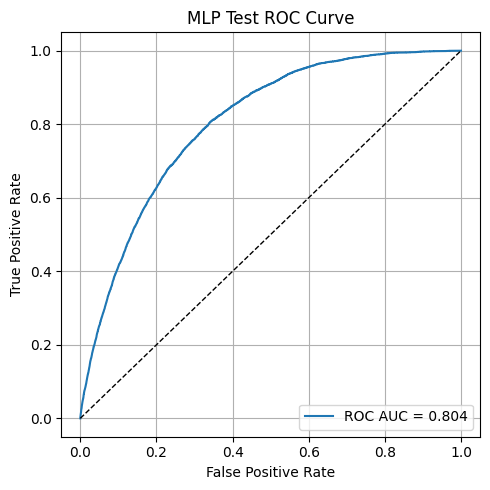

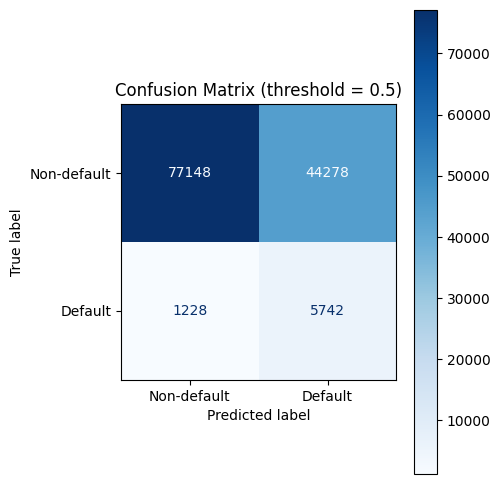

In [ ]:
# Build a test dataset (no shuffling) and evaluate overall metrics
test_ds = df_to_dataset(test_df, shuffle=False)
test_metrics = model.evaluate(test_ds, verbose=0)
print("Test metrics:", dict(zip(model.metrics_names, np.round(test_metrics, 3))))

# Collect true labels and predicted probabilities for detailed analysis
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_pred = np.concatenate([model.predict(x, verbose=0) for x, _ in test_ds]).ravel()

# Plot the ROC curve and compute its AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc     = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP Test ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Build and show the confusion matrix at a 0.5 threshold
y_pred_lbl = (y_pred >= 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred_lbl)
disp = ConfusionMatrixDisplay(cm,
                              display_labels=["Non-default","Default"])
plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Confusion Matrix (threshold = 0.5)")
plt.tight_layout()
plt.show()


On the test set, the MLP achieves about 0.804 AUC, showing it ranks defaults well above chance. The ROC curve confirms this. At the standard 0.5 cutoff, the confusion matrix reveals how many non-defaults and defaults are correctly or incorrectly classified—letting us see the trade-off between catching defaulters and avoiding false alarms at that threshold.

___
14. ### Determine Best Probability Cutoff Using F1-Score  
This cell computes precision and recall for many thresholds on the test set, calculates the F1 score for each cutoff, picks the threshold that maximizes F1, and then plots how precision and recall change with the threshold.


Best threshold by F1: 0.721
 → Precision: 0.191, Recall: 0.419, F1: 0.263


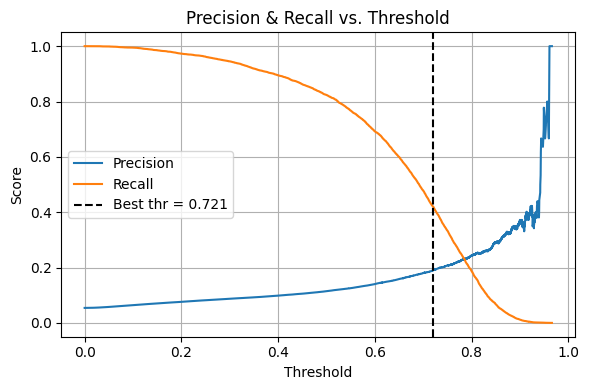

In [ ]:
# Gather true labels and predicted probabilities from our test dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_prob = np.concatenate([model.predict(x, verbose=0)
                        for x, _ in test_ds]).ravel()

# Compute precision and recall at all thresholds
precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)

# Calculate F1 score for each threshold: harmonic mean of precision and recall
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Find the index of the highest F1 and corresponding threshold
best_idx = np.nanargmax(f1_scores)
best_thr = thresholds[best_idx] if best_idx < len(thresholds) else 1.0
best_f1  = f1_scores[best_idx]
best_prec= precisions[best_idx]
best_rec = recalls[best_idx]

# Print the best threshold along with its precision, recall, and F1
print(f"Best threshold by F1: {best_thr:.3f}")
print(f" → Precision: {best_prec:.3f}, Recall: {best_rec:.3f}, F1: {best_f1:.3f}")

# Plot how precision and recall trade off as we vary the cutoff
plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1],    label="Recall")
plt.axvline(best_thr, color='k', linestyle='--', label=f"Best thr = {best_thr:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Threshold")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()



This step finds that a cutoff of ≈0.721 maximizes the F1 score on the test data, giving precision ≈ 0.191 and recall ≈ 0.419 (F1 ≈ 0.263). The plot shows precision rising and recall falling as the threshold increases, and the dashed line marks the best trade-off point where F1 is highest.

___
15. ### Apply Optimal Threshold & Display Metrics  
This cell takes the best cutoff (0.721) we found for balancing precision and recall, uses it to turn predicted probabilities into class labels on the test set, prints the resulting precision, recall, and F1 score, and shows the confusion matrix at that threshold.


Metrics at threshold 0.721:
  Precision: 0.191
  Recall:    0.419
  F1 Score:  0.263



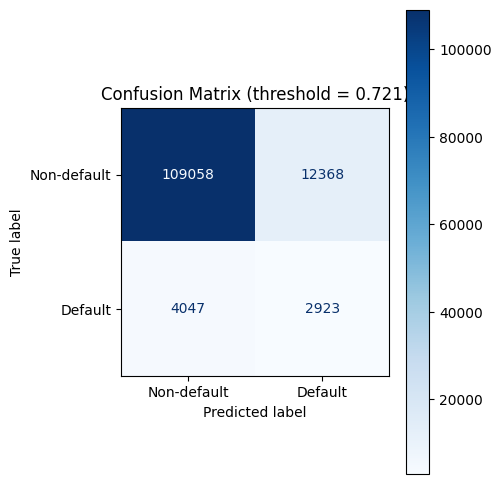

In [ ]:
# Collect true labels and predicted probabilities from our tf.data test set
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_prob = np.concatenate([model.predict(x, verbose=0) for x, _ in test_ds]).ravel()

# Use the best threshold we found earlier
threshold = 0.721

# Convert probabilities into binary predictions using that cutoff
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix, precision, recall, and F1 score
cm   = confusion_matrix(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

# Print out the key metrics at this threshold
print(f"Metrics at threshold {threshold}:")
print(f"  Precision: {prec:.3f}")
print(f"  Recall:    {rec:.3f}")
print(f"  F1 Score:  {f1:.3f}\n")

# Plot the confusion matrix with clear labels
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-default","Default"])
plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.tight_layout()
plt.show()


At the chosen cutoff of 0.721, the MLP achieves precision ≈ 0.191, recall ≈ 0.419, and F1 ≈ 0.263 on the test set. The confusion matrix shows it correctly labels 109,058 non-defaults and 2,923 defaults, while making 12,368 false alarms and missing 4,047 actual defaults. This threshold gives the best balance of catching defaulters and avoiding too many false positives according to the F1 metric.

___
16. ### Compute Accuracy at Optimal Threshold  
This cell applies our best threshold (≈0.721) to the test probabilities and calculates the overall accuracy of those predictions.


In [ ]:
# Convert predicted probabilities into binary labels using best_thr
y_pred = (y_prob >= best_thr).astype(int)

# Compute the accuracy score on the test set
acc = accuracy_score(y_true, y_pred)

# Print the result
print(f"Accuracy at threshold {best_thr:.3f}: {acc:.3f}")


Accuracy at threshold 0.721: 0.872


Using the threshold of 0.726, the model correctly classifies about 87.2 % of all loans (both defaults and non‐defaults), reflecting how well the chosen cutoff balances catching defaulters against mislabeling good loans.

___
17. ### Evaluate MLP on Test Set at Threshold = 0.30  
This cell applies a lower cutoff (0.30) to our predicted probabilities, computes precision, recall, and F1 at that threshold, and shows the resulting confusion matrix so we can see how aggressively catching defaults affects errors.


Metrics at threshold 0.3:
  Precision: 0.087
  Recall:    0.945
  F1 Score:  0.160



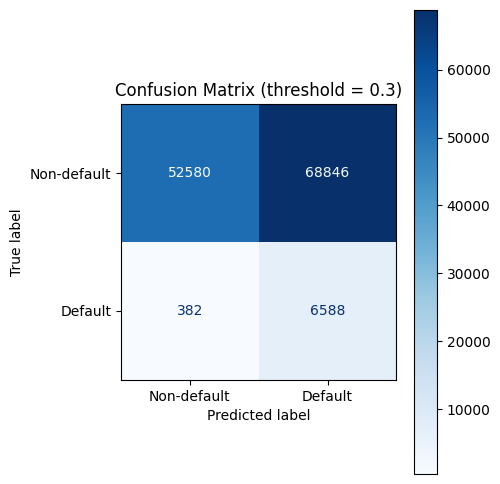

In [ ]:
# Gather the true labels and predicted probabilities as before
y_true = np.concatenate([y.numpy() for _, y in test_ds])
y_prob = np.concatenate([model.predict(x, verbose=0) for x,_ in test_ds]).ravel()

# Set our new, lower threshold
threshold = 0.30

# Convert probabilities into binary predictions at 0.30
y_pred = (y_prob >= threshold).astype(int)

# Compute confusion matrix and key metrics
cm   = confusion_matrix(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec  = recall_score(y_true, y_pred)
f1   = f1_score(y_true, y_pred)

# Print the metrics
print(f"Metrics at threshold {threshold}:")
print(f"  Precision: {prec:.3f}")
print(f"  Recall:    {rec:.3f}")
print(f"  F1 Score:  {f1:.3f}\n")

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-default","Default"])
plt.figure(figsize=(5,5))
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.title(f"Confusion Matrix (threshold = {threshold})")
plt.tight_layout()
plt.show()


At a 0.30 cutoff, the model becomes very “sensitive” to defaults:

True Positives (TP): 6,588 out of 6,970 actual defaulters are caught -> Recall ≈ 94.5 %

False Positives (FP): 68,846 non-defaulters are wrongly flagged -> Precision ≈ 8.7 %

True Negatives (TN): 52,580 non-defaulters correctly passed

False Negatives (FN): only 382 defaulters missed

This yields an F1 score of 0.160. In simple terms, using such a low threshold catches almost every default but at the cost of many false alarms—reflecting the classic precision–recall trade-off.

___
18. ### Compute Accuracy at Threshold = 0.30  
This cell applies our low cutoff of 0.30 to the test probabilities and calculates the overall accuracy, showing the trade-off effect on correct vs. incorrect predictions.


In [ ]:
# Convert probabilities into binary predictions using threshold = 0.30
y_pred = (y_prob >= 0.30).astype(int)

# Compute overall accuracy on the test set
acc = accuracy_score(y_true, y_pred)

# Print the accuracy result
print(f"Accuracy at threshold 0.30: {acc:.3f}")


Accuracy at threshold 0.30: 0.461


At a 0.30 cutoff, the model’s overall accuracy drops to 46.1%. This happens because although we catch nearly all defaulters (high recall), the huge number of false alarms (low precision) means only half of all predictions are correct at this aggressive threshold.

***Save the Trained Model to Google Drive***

In [ ]:
model.save('/content/drive/MyDrive/MLP_model.h5')
print("Model saved to Drive as MLP_model.h5")

Model saved to Drive as MLP_model.h5
